In [1]:

import numpy as np # used for handling numbers
import pandas as pd # used for handling the dataset
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
from sklearn.model_selection import train_test_split # used for splitting training and testing data
from sklearn.preprocessing import StandardScaler # used for feature scaling



import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.utils import shuffle



from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error



#reading the dataset
df = pd.read_csv('10_data_trimed_attack_noAttack.csv')

def read_dataset():
    #print
    X = df[df.columns[0:42]].values
    y = df[df.columns[41]]
    
    
    #encode the dependant variable
    Y = one_hot_encode(y)
    print(X.shape)
    print(Y.shape)
    return(X,Y)

#define one-hot-encoder function
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels, n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

#Read the dataset
X, Y = read_dataset()

#shufffle the dataset to mix up the rows
X,Y = shuffle(X, Y,random_state = 1)

#dataset into train & test 
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.20, random_state=415)

#shapes of the training and testing
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

#define the important parameters and variables to work with the tensors
initial_learning_rate = 0.9
decay_steps = 10000
decay_rate = 0.96
training_epochs = 500
cost_history = np.empty(shape=[1], dtype=float)
n_dim = X.shape[1]
print("n_dim", n_dim)
n_class = 2
model_path = "model"

#define the number of hidden layers and number of neurons for each layer
n_hidden_1 = 200
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 200
n_hidden_5 = 100

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)

x = tf.placeholder(tf.float32, [None, n_dim])
W = tf.Variable(tf.zeros([n_dim, n_class]))
b = tf.Variable(tf.zeros([n_class]))
y_ = tf.placeholder(tf.float32, [None, n_class])


#define the model

def attack_finder(x, weights, biases):
    
    #1st activation function
    layer_1 = tf.add(tf.matmul(x, weights["h1"]), biases["b1"])
    layer_1 = tf.nn.relu(layer_1)
    
    #2nd activation function
    layer_2 = tf.add(tf.matmul(layer_1, weights["h2"]), biases["b2"])
    layer_2 = tf.nn.sigmoid(layer_2)
     
    #3rd activation function
    layer_3 = tf.add(tf.matmul(layer_2, weights["h3"]), biases["b3"])
    layer_3 = tf.nn.sigmoid(layer_3)
     
    #4th activation function
    layer_4 = tf.add(tf.matmul(layer_3, weights["h4"]), biases["b4"])
    layer_4 = tf.nn.relu(layer_4)
     
    #5th activation function
    layer_5 = tf.add(tf.matmul(layer_4, weights["h5"]), biases["b5"])
    layer_5 = tf.nn.sigmoid(layer_5)
    
    #outer layer relu activation function
    out_layer = tf.add(tf.matmul(layer_5, weights["out"]), biases["out"])
    out_layer = tf.nn.softmax(out_layer)
    
    return out_layer


#Define the weights and biases for each layer

weights = {
    "h1" : tf.Variable(tf.truncated_normal([n_dim, n_hidden_1])),
    "h2" : tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2])),
    "h3" : tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3])),
    "h4" : tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_4])),
    "h5" : tf.Variable(tf.truncated_normal([n_hidden_4, n_hidden_5])),
    "out" : tf.Variable(tf.truncated_normal([n_hidden_5, n_class]))
}
biases = {
    "b1" : tf.Variable(tf.truncated_normal([n_hidden_1])),
    "b2" : tf.Variable(tf.truncated_normal([n_hidden_2])),
    "b3" : tf.Variable(tf.truncated_normal([n_hidden_3])),
    "b4" : tf.Variable(tf.truncated_normal([n_hidden_4])),
    "b5" : tf.Variable(tf.truncated_normal([n_hidden_5])),
    "out" : tf.Variable(tf.truncated_normal([n_class]))
}


# Initialize all the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Call your model defined
y = attack_finder(x, weights, biases)

print(y_.shape)


#define the cost function and optimizer
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, labels=y_))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function, global_step=global_step)

sess = tf.Session()
sess.run(init)


#calculate the cost and accuracy for each epoch

mse_history = []
accuracy_history = []
# Initialize the variable to keep track of the highest accuracy
highest_accuracy = 0.0

for epoch in range(training_epochs):
    sess.run(training_step, feed_dict={x:train_x, y_: train_y})
    cost = sess.run(cost_function, feed_dict={x:train_x, y_: train_y})
    cost_history = np.append(cost_history, cost)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    current_accuracy = sess.run(accuracy, feed_dict={x:test_x, y_: test_y})
    accuracy_history.append(current_accuracy)
    #print('Epoch: {:04d} - cost: {:.9f} - accuracy: {:.4f}'.format(epoch + 1, cost, current_accuracy))
    
    
    # Save the model if the current accuracy is higher than the previous highest accuracy
    if current_accuracy > highest_accuracy:
        save_path = saver.save(sess, model_path)
        print("Model saved in file: %s" % save_path)
        highest_accuracy = current_accuracy

    
    pred_y = sess.run(y, feed_dict ={x:test_x})
    mse = tf.reduce_mean(tf.square(pred_y - test_y))
    mse_ = sess.run(mse)
    mse_history.append(mse_)
    #accuracy_point = (sess.run(accuracy, feed_dict={x: train_x, y_: train_y}))
    #accuracy_history.append(current_accuracy)
    
    print("epoch : ", epoch, "-", "cost: ", cost, "- MSE: ", mse_, "- train Accuracy: ", current_accuracy)
    
#save_path = saver.save(sess, model_path)
print("Model saved in file: %s" % save_path)



2023-03-26 19:35:44.327493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 19:35:44.422977: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-26 19:35:44.425330: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-26 19:35:44.425340: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Instructions for updating:
non-resource variables are not supported in the long term
(494020, 42)
(494020, 2)
(395216, 42)
(395216, 2)
(98804, 42)
(98804, 2)
n_dim 42
(?, 2)


2023-03-26 19:35:46.012339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 19:35:46.012479: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-26 19:35:46.012525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-26 19:35:46.012550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-26 19:35:46.012580: W tensorflow/c

Model saved in file: model
epoch :  0 - cost:  0.50898147 - MSE:  0.19686236454495074 - train Accuracy:  0.80187035
Model saved in file: model
epoch :  1 - cost:  0.50772315 - MSE:  0.19524447882450188 - train Accuracy:  0.8027003
Model saved in file: model
epoch :  2 - cost:  0.4991936 - MSE:  0.18563859394722743 - train Accuracy:  0.80989635
Model saved in file: model
epoch :  3 - cost:  0.48455137 - MSE:  0.1698004133265336 - train Accuracy:  0.8271224
Model saved in file: model
epoch :  4 - cost:  0.45818877 - MSE:  0.14292105660735308 - train Accuracy:  0.85495526
Model saved in file: model
epoch :  5 - cost:  0.45218974 - MSE:  0.13696025771322687 - train Accuracy:  0.8592871
Model saved in file: model
epoch :  6 - cost:  0.44531932 - MSE:  0.12963768580121535 - train Accuracy:  0.8669386
Model saved in file: model
epoch :  7 - cost:  0.43933046 - MSE:  0.12249656669900834 - train Accuracy:  0.86947894
Model saved in file: model
epoch :  8 - cost:  0.43274003 - MSE:  0.1151678651

epoch :  75 - cost:  0.33239165 - MSE:  0.01318112525219618 - train Accuracy:  0.98468685
epoch :  76 - cost:  0.32906678 - MSE:  0.012446093118562743 - train Accuracy:  0.98560786
epoch :  77 - cost:  0.32851815 - MSE:  0.012149505912970112 - train Accuracy:  0.9860127
epoch :  78 - cost:  0.32804525 - MSE:  0.011860732294596167 - train Accuracy:  0.9862151
epoch :  79 - cost:  0.3277075 - MSE:  0.011706051785714636 - train Accuracy:  0.98635685
epoch :  80 - cost:  0.32750288 - MSE:  0.01159638098266276 - train Accuracy:  0.98642766
epoch :  81 - cost:  0.32728308 - MSE:  0.01146968856981305 - train Accuracy:  0.98656934
epoch :  82 - cost:  0.32696715 - MSE:  0.011247389591185724 - train Accuracy:  0.98707545
epoch :  83 - cost:  0.3267739 - MSE:  0.011146883520719374 - train Accuracy:  0.98719686
epoch :  84 - cost:  0.3266595 - MSE:  0.011071349908262829 - train Accuracy:  0.98732847
epoch :  85 - cost:  0.32655802 - MSE:  0.01103188628855616 - train Accuracy:  0.9873791
epoch :  

Model saved in file: model
epoch :  161 - cost:  0.3238552 - MSE:  0.009418281682092473 - train Accuracy:  0.9899599
Model saved in file: model
epoch :  162 - cost:  0.32374397 - MSE:  0.009399791296662005 - train Accuracy:  0.9900105
Model saved in file: model
epoch :  163 - cost:  0.32367238 - MSE:  0.009395146036681956 - train Accuracy:  0.99003077
Model saved in file: model
epoch :  164 - cost:  0.32361576 - MSE:  0.009339284149010503 - train Accuracy:  0.99010164
epoch :  165 - cost:  0.32357204 - MSE:  0.009352861626816566 - train Accuracy:  0.99002063
epoch :  166 - cost:  0.32352924 - MSE:  0.009325722998904466 - train Accuracy:  0.9900611
epoch :  167 - cost:  0.32351005 - MSE:  0.009340794793864085 - train Accuracy:  0.99003077
Model saved in file: model
epoch :  168 - cost:  0.3235073 - MSE:  0.0092887526086678 - train Accuracy:  0.9901117
epoch :  169 - cost:  0.32344693 - MSE:  0.009291396422759784 - train Accuracy:  0.9901117
epoch :  170 - cost:  0.32340318 - MSE:  0.009

epoch :  246 - cost:  0.33017012 - MSE:  0.012294071345944079 - train Accuracy:  0.9895956
epoch :  247 - cost:  0.333056 - MSE:  0.012807881504722852 - train Accuracy:  0.98749036
epoch :  248 - cost:  0.32817334 - MSE:  0.011685026193556521 - train Accuracy:  0.98709565
epoch :  249 - cost:  0.32590976 - MSE:  0.011032785843089608 - train Accuracy:  0.98771304
epoch :  250 - cost:  0.32545736 - MSE:  0.010842540434657932 - train Accuracy:  0.98806727
epoch :  251 - cost:  0.32520637 - MSE:  0.010699760703475015 - train Accuracy:  0.9879559
epoch :  252 - cost:  0.32500768 - MSE:  0.010604106307387813 - train Accuracy:  0.9881685
epoch :  253 - cost:  0.32499495 - MSE:  0.010612506532370392 - train Accuracy:  0.9881786
epoch :  254 - cost:  0.32478085 - MSE:  0.01048878675281204 - train Accuracy:  0.9884114
epoch :  255 - cost:  0.3246222 - MSE:  0.010387065262535104 - train Accuracy:  0.98853284
epoch :  256 - cost:  0.32451293 - MSE:  0.010329679696778294 - train Accuracy:  0.988522

epoch :  335 - cost:  0.32211128 - MSE:  0.008545195025475587 - train Accuracy:  0.9906077
epoch :  336 - cost:  0.32210267 - MSE:  0.008489362461026526 - train Accuracy:  0.99069875
epoch :  337 - cost:  0.32208917 - MSE:  0.008446949390267185 - train Accuracy:  0.9907392
epoch :  338 - cost:  0.32203573 - MSE:  0.008436920785394895 - train Accuracy:  0.990719
epoch :  339 - cost:  0.32201928 - MSE:  0.008414756152953423 - train Accuracy:  0.9908101
epoch :  340 - cost:  0.32200477 - MSE:  0.008400558600343336 - train Accuracy:  0.99085057
epoch :  341 - cost:  0.32198304 - MSE:  0.008363183035581362 - train Accuracy:  0.99084044
epoch :  342 - cost:  0.3220038 - MSE:  0.008411428605403682 - train Accuracy:  0.9908303
Model saved in file: model
epoch :  343 - cost:  0.3219303 - MSE:  0.00826536862572206 - train Accuracy:  0.99104285
Model saved in file: model
epoch :  344 - cost:  0.3219147 - MSE:  0.008266987270360834 - train Accuracy:  0.991053
Model saved in file: model
epoch :  34

epoch :  419 - cost:  0.3215219 - MSE:  0.008009439096292956 - train Accuracy:  0.99169064
epoch :  420 - cost:  0.32147858 - MSE:  0.007906409368246556 - train Accuracy:  0.9917311
Model saved in file: model
epoch :  421 - cost:  0.32143962 - MSE:  0.00786647769502454 - train Accuracy:  0.99179184
Model saved in file: model
epoch :  422 - cost:  0.32138357 - MSE:  0.007759979937649441 - train Accuracy:  0.9918829
epoch :  423 - cost:  0.3213962 - MSE:  0.007744066930538362 - train Accuracy:  0.9918829
epoch :  424 - cost:  0.3216369 - MSE:  0.008077313317736473 - train Accuracy:  0.99151856
epoch :  425 - cost:  0.32153374 - MSE:  0.007866502155944208 - train Accuracy:  0.99165016
epoch :  426 - cost:  0.32144886 - MSE:  0.007898871601022086 - train Accuracy:  0.991721
epoch :  427 - cost:  0.32145694 - MSE:  0.007924511462359845 - train Accuracy:  0.9917311
epoch :  428 - cost:  0.32143107 - MSE:  0.007908925576168242 - train Accuracy:  0.9917716
epoch :  429 - cost:  0.3213846 - MSE

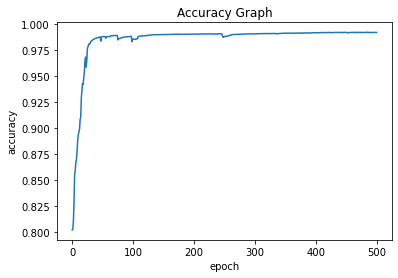

In [2]:
#plot Accuracy Graph
plt.plot(accuracy_history)
plt.title("Accuracy Graph")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

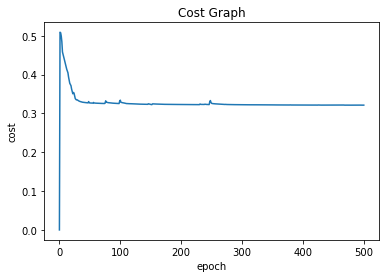

In [3]:
#plot Cost Graph
plt.plot(cost_history)
plt.title("Cost Graph")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.show()

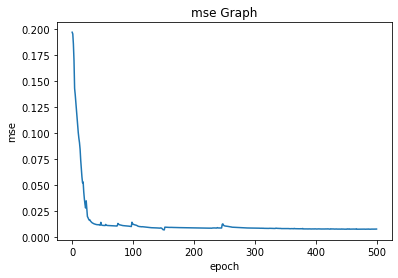

In [4]:
#plot mse Graph
plt.plot(mse_history)
plt.title("mse Graph")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

In [5]:
#print final accuracy

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))            
print("accuracy: ", highest_accuracy)                             


accuracy:  0.992055


In [6]:
#print the final mean sq error
pred_y = sess.run(y, feed_dict={x:test_x})
mse = tf.reduce_mean(tf.square(pred_y) - test_y)                              
print ("Mse: %.4f" % sess.run(mse)) 

Mse: -0.0015


In [7]:
pred_y

array([[2.5707113e-05, 9.9997419e-01],
       [5.6593044e-04, 9.9943411e-01],
       [9.9999899e-01, 9.2220813e-07],
       ...,
       [2.5706920e-05, 9.9997425e-01],
       [6.3077678e-05, 9.9993694e-01],
       [2.5707115e-05, 9.9997425e-01]], dtype=float32)

In [8]:
test_x

array([[0., 2., 9., ..., 0., 0., 1.],
       [0., 2., 9., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 2., 9., ..., 0., 0., 1.],
       [0., 2., 9., ..., 0., 0., 1.],
       [0., 2., 9., ..., 0., 0., 1.]])


plt.plot(range(len(cost_history)),cost_history)
plt.plot(range(len(accuracy_history)),accuracy_history)
plt.legend(['Cost','Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Cost/Accuracy')
plt.title('Learning Curve')
plt.show()

# Plot mse and accuracy graph
plt.plot(mse_history, 'r')
plt.show()
plt.plot(accuracy_history)
plt.show()

#Once the model is trained, we can apply cross validation

#Define KFold
kf = KFold(n_splits=5)

#Define the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

#loop through the KFold splits
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #fit the model on the training data
    knn.fit(X_train, y_train)
    
    #predict on the test data
    y_pred = knn.predict(X_test)
    
    #calculate the mean absolute error
    mae = mean_absolute_

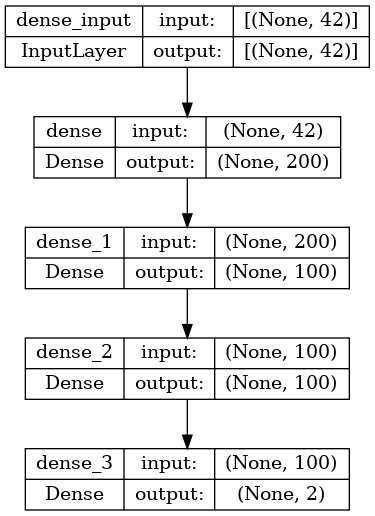

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


# Define the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(n_hidden_1, activation='relu', input_shape=(n_dim,)))
model.add(tf.keras.layers.Dense(n_hidden_2, activation='sigmoid'))
model.add(tf.keras.layers.Dense(n_hidden_3, activation='softmax'))
model.add(tf.keras.layers.Dense(n_class, activation='softmax'))

# Save the model to a file
tf.keras.utils.plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)
